# Imports

In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from joblib import parallel_backend, Parallel, delayed
num_cores = 10
import time

from scipy.integrate import odeint
from scipy.integrate import simps
from scipy.optimize import minimize

import seaborn as sns
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib import colors
import matplotlib as mpl

import pickle

import time
import copy

import os

import importlib

In [2]:
from ionization import Transmon_Module as TM
from ionization import Transmon_Module_numpy as TM_np

from ionization import branch_analysis as BA
from ionization import floquet_analysis as FA

# importlib.reload(FA)

In [3]:
import sys
sys.path.insert(1, "/Users/dumm3209/Desktop/Codes/VScode/PrettyPlots")
import pretty_plots 
list_colors = pretty_plots.list_colors

# Units

In [4]:
GHz,MHz,kHz = 2*np.pi,2*np.pi*1e-3,2*np.pi*1e-6
ns,us,ms = 1,1e3,1e6

# Main 

In [5]:
# PARAMÈTRES DIAGONALISATION 
max_charge = 200
n_trunc = 31
max_fock = 10


# Transmon

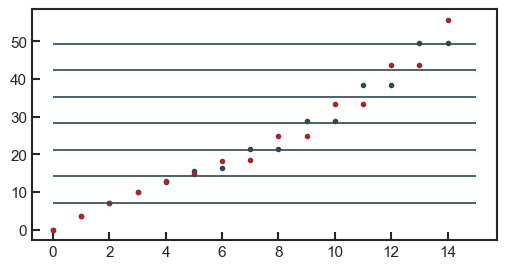

In [6]:
E_J_a_m = [8.717862654789487*GHz, -0.06694206359451146*GHz, 0.0034684306473925027*GHz]
E_J_b_m = [0, 0, 0]
E_C = 0.2166222390426093*GHz
g = 0.18647882941197633*GHz
omega_r = 7.047670130602469*GHz
omega_d = 7.0535*GHz

for n_g in [0,0.5]:
    
    Transmon_params = {'E_J_a_m':E_J_a_m,'E_J_b_m':E_J_b_m,'E_C':E_C,'g':g,'omega_r':omega_r,'max_charge':max_charge,'max_fock':max_fock,'n_trunc':n_trunc,'n_g':n_g}

    transmon_cavity = TM.Transmon_Cavity(Transmon_params)

    transmon = transmon_cavity.Transmon
    eigs_t = transmon.E
    eigv_t = transmon.Eigvecs
    H_t = transmon.H_t_eigbasis  # Hamiltonien diagonal
    I_t = transmon.I_t
    n_t = transmon.n_t_eigbasis  # charge operator in transmon eigenbasis
    omega_q = transmon.omega_q

    plt.plot((eigs_t[0:15]-np.min(eigs_t))/GHz,'.')

for i in range(1,8):
    plt.hlines(i*omega_d/GHz,0,15)


(150.0, 250.0)

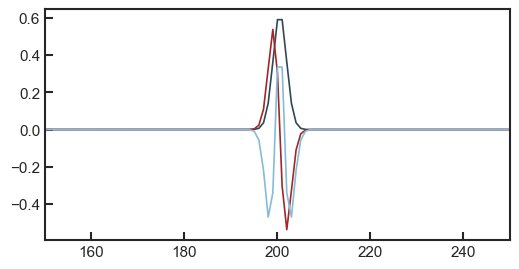

In [7]:
plt.plot(np.real(eigv_t[0].full()))
plt.plot(np.real(eigv_t[1].full()))
plt.plot(np.real(eigv_t[2].full()))

plt.xlim(150,250)

(-10.0, 10.0)

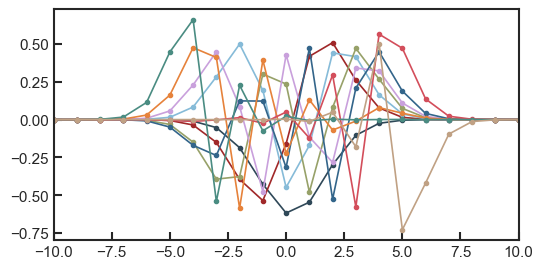

In [8]:
n_g = 0.25
Transmon_params = {'E_J_a_m':E_J_a_m,'E_J_b_m':E_J_b_m,'E_C':E_C,'g':g,'omega_r':omega_r,'max_charge':max_charge,'max_fock':max_fock,'n_trunc':n_trunc,'n_g':n_g}

transmon_cavity = TM.Transmon_Cavity(Transmon_params)

transmon = transmon_cavity.Transmon
eigs_t = transmon.E
eigv_t = transmon.Eigvecs
H_t = transmon.H_t_eigbasis  # Hamiltonien diagonal
I_t = transmon.I_t
n_t = transmon.n_t_eigbasis  # charge operator in transmon eigenbasis
omega_q = transmon.omega_q

charge = np.arange(-max_charge,max_charge+1)

for i in range(10):
    plt.plot(charge,np.real(eigv_t[i].full()),'.-')

plt.xlim(-10,10)


(-10.0, 10.0)

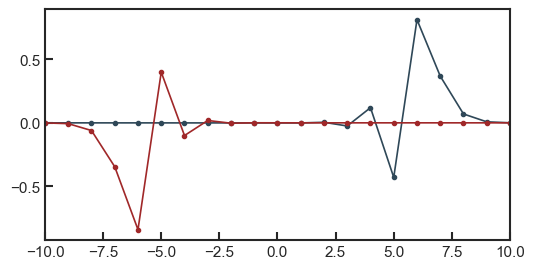

In [9]:
plt.plot(charge,np.real((eigv_t[11]).full()),'.-')
plt.plot(charge,np.real((eigv_t[12]).full()),'.-')

plt.xlim(-10,10)

(-30.0, 30.0)

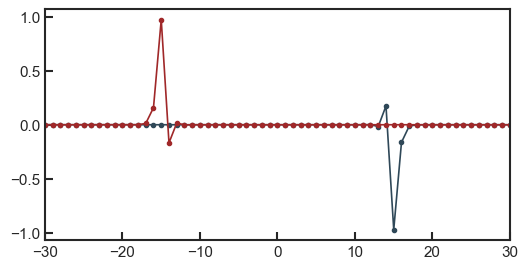

In [10]:
i = 29

plt.plot(charge,np.real((eigv_t[i]).full()),'.-')
plt.plot(charge,np.real((eigv_t[i+1]).full()),'.-')

plt.xlim(-30,30)


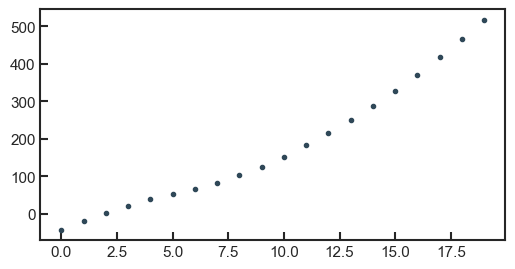

In [11]:
plt.plot(eigs_t[0:20],'.')

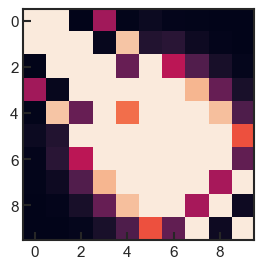

In [12]:
plt.imshow(np.abs((n_t).full())[:10,0:10],vmax=0.1)

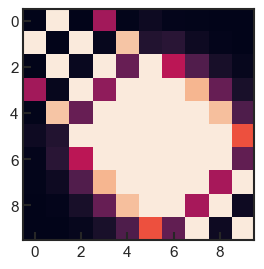

In [13]:
plt.imshow(np.abs((n_t-n_g).full())[:10,0:10],vmax=0.1)

In [14]:
# Xander parameters for IST
E_J = 4.45 * GHz
E_L = 4.44 * GHz
E_C = 1 * GHz
type_qubit = "L_shunt"
phi_ext = np.pi
g = 100 * MHz
omega_r = 6*GHz
omega_d = omega_r
n_g = 0
Transmon_params = {'E_J':E_J,'E_L':E_L,'phi_ext':phi_ext,'n_g':n_g,'E_C':E_C,'g':g,'omega_r':omega_r,'max_fock':max_fock,'n_trunc':n_trunc,'type':type_qubit}

transmon_cavity = TM.Transmon_Cavity(Transmon_params)

transmon = transmon_cavity.Transmon
eigs_t = transmon.E
eigv_t = transmon.Eigvecs
H_t = transmon.H_t_eigbasis  # Hamiltonien diagonal
I_t = transmon.I_t
n_t = transmon.n_t_eigbasis  # charge operator in transmon eigenbasis
omega_q = transmon.omega_q


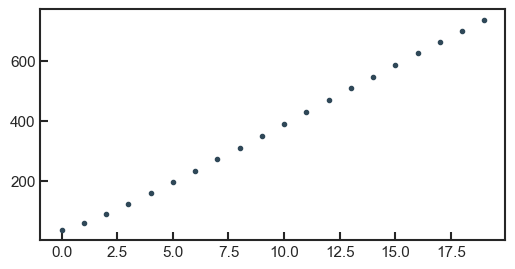

In [15]:
plt.plot(eigs_t[0:20],'.')

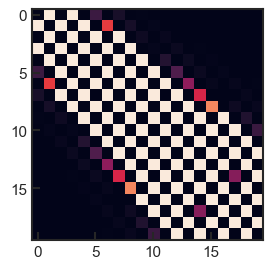

In [16]:
plt.imshow(np.abs(n_t.full()[0:20,0:20]),vmax=0.01)

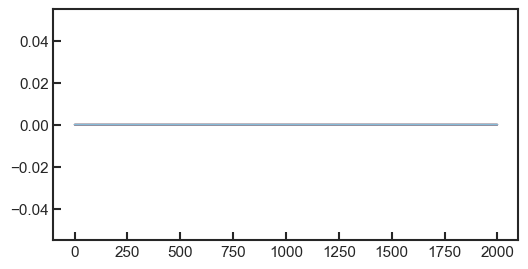

In [17]:
plt.plot(np.imag(eigv_t[0].full()))
plt.plot(np.imag(eigv_t[1].full()))
plt.plot(np.imag(eigv_t[2].full()))

#plt.xlim(150,250)

# Floquet

In [18]:
# PARAMÈTRES DIAGONALISATION 
max_charge = 200
n_trunc = 31
max_fock = 10

param_type = 'PRX'

if param_type == 'KIT' :
    # physical parameters : KIT transmon
    E_J_a_m = [8.717862654789487*GHz, -0.06694206359451146*GHz, 0.0034684306473925027*GHz]
    E_J_b_m = [0, 0, 0]
    E_C = 0.2166222390426093*GHz
    g = 0.18647882941197633*GHz
    omega_r = 7.047670130602469*GHz
    omega_d = 7.0535*GHz
    n_g = 0.2
    Transmon_params = {'E_J_a_m':E_J_a_m,'E_J_b_m':E_J_b_m,'E_C':E_C,'g':g,'omega_r':omega_r,'max_charge':max_charge,'max_fock':max_fock,'n_trunc':n_trunc,'n_g':n_g}


elif param_type == 'Xander IST' :
    # Xander parameters for IST
    E_J = 4.45 * GHz
    E_L = 4.44 * GHz
    E_C = 1 * GHz
    type_qubit = "L_shunt"
    phi_ext = np.pi
    g = 100 * MHz
    omega_r = 6*GHz
    omega_d = omega_r
    n_g = 0
    Transmon_params = {'E_J':E_J,'E_L':E_L,'phi_ext':phi_ext,'n_g':n_g,'E_C':E_C,'g':g,'omega_r':omega_r,'max_fock':max_fock,'n_trunc':n_trunc,'type':type_qubit}


elif param_type == 'PRX' :
    # Xander parameters for IST
    E_C = 220 * MHz
    E_J = 110 * E_C
    type_qubit = "transmon"
    phi_ext = 0
    g = 120 * MHz
    omega_r = 7.5 * GHz
    omega_d = 7.515 * GHz
    n_g = 0
    Transmon_params = {'E_J':E_J,'phi_ext':phi_ext,'n_g':n_g,'E_C':E_C,'g':g,'omega_r':omega_r,'max_fock':max_fock,'n_trunc':n_trunc,'type':type_qubit}


else:
    print('wrong parameter type')

In [19]:
#Floquet
max_fock_floquet = 200
photons = np.linspace(0,max_fock_floquet,max_fock_floquet+1)
eps_d_step = 10 * MHz
eps_d_max = 2 * g * np.sqrt(max_fock_floquet)
#eps_d_vec = np.arange(0,eps_d_max,eps_d_step)
eps_d_vec = 2 * g * np.sqrt(photons)
N_times = 1
N_periods = 1
phi = 0

print(len(eps_d_vec))

201


In [20]:
photons

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [21]:
# FLOQUET : generate and track

transmon_cavity = TM.Transmon_Cavity(Transmon_params)

transmon = transmon_cavity.Transmon
eigs_t = transmon.E
eigv_t = transmon.Eigvecs
H_t = transmon.H_t_eigbasis  # Hamiltonien diagonal
I_t = transmon.I_t
n_t = transmon.n_t_eigbasis  # charge operator in transmon eigenbasis
omega_q = transmon.omega_q
n_g = transmon.n_g

Floquet_params = {'n_t':n_t,'I_t':I_t,'H_t':H_t,'n_g':n_g,'num_cores':5,'omega_d':omega_d,'phi':phi,'eps_d_vec':eps_d_vec,'N_times':N_times,'N_periods':N_periods}

index_FA,f_energies,f_modes_0 = FA.generate_FA(Floquet_params,verbose=0)

Invalid type, using transmon type. For L-shunted transmon, please use L_shunt


In [22]:
overlap_max,f_modes_0_sorted,f_energies_sorted,index_Floquet = FA.track(n_trunc,f_energies,f_modes_0,Floquet_params,Transmon_params,eigs_t)

In [23]:
overlap_tot = FA.calculate_overlap_tot(n_trunc,f_modes_0_sorted,eps_d_vec)

In [24]:
########### Find Floquet resonances with overlap ############
N_t_sorted=[]
for q in range(n_trunc):
    N_t_q_sorted=[]
    for i in range(len(eps_d_vec)):
        N_t_q_sorted.append(FA.N_t(f_modes_0_sorted[q][i],Transmon_params))    
    N_t_sorted.append(np.array(N_t_q_sorted))

Text(0, 0.5, '$N_t$')

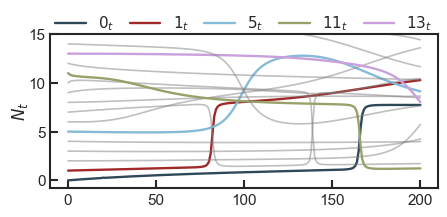

In [25]:
lwidth=1.7
plt.figure(figsize=(5,2))

for q in range(n_trunc):
    if q>1 and q!=11 and q!=5 and q!=13:
        plt.plot((eps_d_vec/2/g)**2,N_t_sorted[q],c='grey',alpha=0.5)
    else:
        plt.plot((eps_d_vec/2/g)**2,N_t_sorted[q],linewidth=lwidth,label='$i_t=0_t$')

legend_elements = [mpl.lines.Line2D([0], [0], c=list_colors[0], ls='-',lw=lwidth, label=r'$0_t$'),
                   mpl.lines.Line2D([0], [0], c=list_colors[1], ls='-',lw=lwidth, label=r'$1_t$'),
                   mpl.lines.Line2D([0], [0], c=list_colors[2], ls='-',lw=lwidth, label=r'$5_t$'),
                   mpl.lines.Line2D([0], [0], c=list_colors[3], ls='-',lw=lwidth, label=r'$11_t$'),
                   mpl.lines.Line2D([0], [0], c=list_colors[4], ls='-',lw=lwidth, label=r'$13_t$')]


plt.legend(handles=legend_elements, loc=(0,0.98),  ncol=5,columnspacing=1.02, frameon=False)

plt.ylim(-0.8,15)
#plt.xlim(0,200)

plt.ylabel('$N_t$',labelpad=-1)
#plt.savefig('Floquet_BA.pdf',transparent=True)

(-3.7575000000000003, 3.7575000000000003)

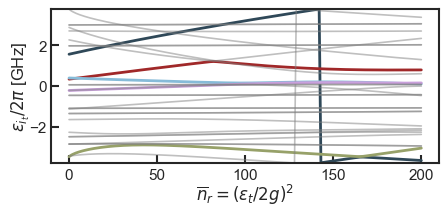

In [53]:
plt.figure(figsize=(5,2))

i_cut=391
for q in range(n_trunc):
    if q==3:
        plt.plot((eps_d_vec[:i_cut]/2/g)**2,np.array(f_energies_sorted[q][:i_cut])/GHz,c='grey',alpha=0.5)
        plt.plot((eps_d_vec[i_cut:]/2/g)**2,np.array(f_energies_sorted[q][i_cut:])/GHz,c='grey',alpha=0.5)

    elif q>1 and q!=11 and q!=5 and q!=13:
        plt.plot((eps_d_vec/2/g)**2,np.array(f_energies_sorted[q])/GHz,c='grey',alpha=0.5)
    else:
        plt.plot((eps_d_vec/2/g)**2,np.array(f_energies_sorted[q])/GHz,linewidth=2)

plt.xlabel(r'$\overline{n}_r=(\varepsilon_t/2g)^2$',labelpad=0)
plt.ylabel(r'$\varepsilon_{i_t}/2\pi$ [GHz]',labelpad=-2)
#plt.xlim(0,200)
plt.ylim(-omega_d/2/GHz,omega_d/2/GHz)

#plt.savefig('Floquet_quasi.pdf',transparent=True, bbox_inches='tight')

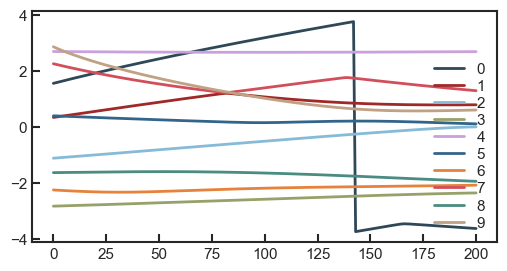

In [ ]:
for q in range(10):
    plt.plot((eps_d_vec/2/g)**2,np.array(f_energies_sorted[q])/GHz,linewidth=2,label=q)

plt.legend(loc='lower right')
 

(0.0, 15.0)

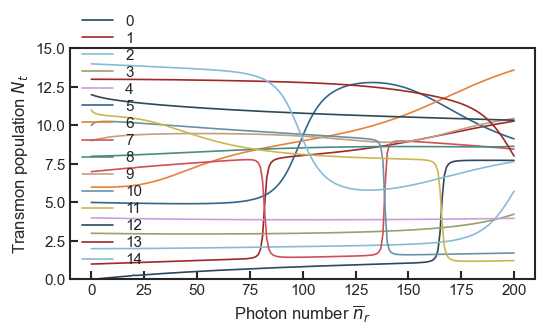

In [27]:
i=1
for q in range(15):
    plt.plot((eps_d_vec/2/g)**2,N_t_sorted[q],c=list_colors[q%12],label=q)
    
plt.xlabel('Photon number $\overline{n}_r$')
plt.ylabel('Transmon population $N_t$')
plt.legend()
plt.ylim(0,15)

In [28]:
index_1_photon = np.argmin(np.abs((eps_d_vec/2/g)**2 - 1))

print((eps_d_vec[index_1_photon]/2/g)**2)

chi_0 = f_energies_sorted[0][index_1_photon] - f_energies_sorted[0][0] 

chi_1 = f_energies_sorted[1][index_1_photon] - f_energies_sorted[1][0]

omega_r_0 = omega_r + chi_0

omega_r_1 = omega_r + chi_1

print((chi_0)/MHz)
print((chi_1)/MHz)

print((chi_1-chi_0)/MHz)

print(omega_r_0/GHz)

print(omega_r_1/GHz)

1.0
19.25572472937525
11.046739294523265
-8.208985434851982
7.5192557247293745
7.511046739294523


In [41]:

def chi_i_numerics(i):
    
    index_1_photon = np.argmin(np.abs((eps_d_vec/2/g)**2 - 1))

    if np.abs((eps_d_vec[index_1_photon]/2/g)**2 - 1) > 0.001 :
        print('not good sampling of photon number')

    chi_i = f_energies_sorted[i][index_1_photon] - f_energies_sorted[i][0] 

    return chi_i


def chi_i_theo(i,omega_r = omega_r):
    
    chi_i = 0
    chi_i_j_all = []
    
    for j in range(n_trunc):
        omega_ij = eigs_t[j] - eigs_t[i]
        chi_i_j = 2 * g**2 * omega_ij * np.abs(n_t[i,j])**2 / (omega_r**2 - omega_ij**2)

        chi_i += chi_i_j
        chi_i_j_all.append(chi_i_j)

    return chi_i,np.array(chi_i_j_all)


chi_0,chi_0_j = chi_i_theo(0)
chi_1,chi_1_j = chi_i_theo(1)

print(chi_0/MHz)
print(chi_1/MHz)

print((chi_1-chi_0)/MHz)

19.563887678976368
11.13390695494602
-8.429980724030345


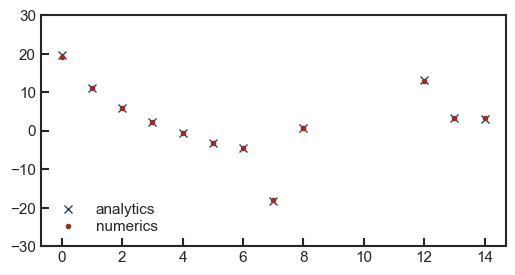

In [51]:
i_max = 15

chi_i_analytics_all = []
chi_i_j_analytics_all = []
for i in range(i_max):
    chi_i,chi_i_j = chi_i_theo(i)
    chi_i_analytics_all.append(chi_i)
    chi_i_j_analytics_all.append(chi_i_j)
chi_i_analytics_all = np.array(chi_i_analytics_all)
chi_i_j_analytics_all = np.array(chi_i_j_analytics_all)

plt.plot(chi_i_analytics_all/MHz,'x',label='analytics')


chi_i_numerics_all = []
for i in range(i_max):
    chi_i_numerics_all.append(chi_i_numerics(i))
chi_i_numerics_all = np.array(chi_i_numerics_all)

plt.plot(chi_i_numerics_all/MHz,'.',label='numerics')

plt.ylim(-30,30)
plt.legend()


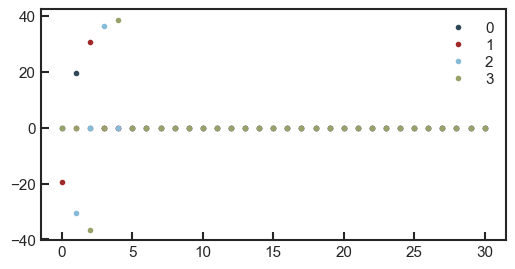

In [44]:
for i in range(4):
    plt.plot(chi_i_j_analytics_all[i]/MHz,'.',label = i)
plt.legend()

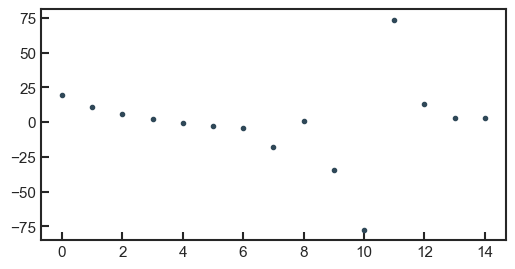

In [46]:
plt.plot(chi_i_analytics_all/MHz,'.',label = i)


## Find resonances automatically

In [152]:
import importlib
importlib.reload(FA)

<module 'ionization.floquet_analysis' from '/Users/dumm3209/Desktop/Codes/VScode/ionization/ionization/floquet_analysis.py'>

In [153]:
param_resonances={'index_min':0,
                 'value_min':1e-5,
                 'ratio_v':1,
                 'FWHM_size_min':5,
                 'FWHM_overlap_min':1e-5}

res_q_sort_clean,swap_statements,index_crit_tot,branch_tot,f_energies_sorted_q_tot,N_t_sorted_q_tot,gap_tot = FA.find_resonance_overlaps(f_energies_sorted,N_t_sorted,overlap_tot,param_resonances)

In [154]:
np.array(f_energies_sorted).shape

(31, 201)

In [155]:
np.array(N_t_sorted).shape

(31, 201)

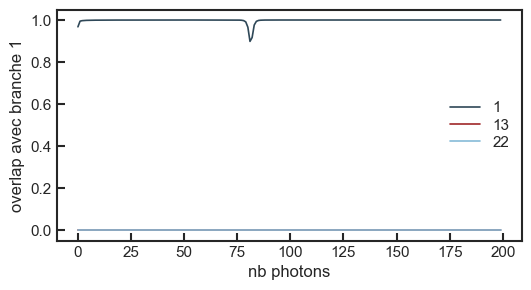

In [156]:
for i in [1,13,22]:
    plt.plot(overlap_tot[:,1,i],label = i)

plt.xlabel('nb photons')
plt.ylabel('overlap avec branche 1')
plt.legend()

In [157]:
resonance_all=[]

for q in [0,1]:
    resonance_all_q = []
    if len(index_crit_tot[q])>0:
        eps_d_crit = eps_d_vec[index_crit_tot[q]]

        for i in range(len(eps_d_crit)):
            resonance_all_q.append([eps_d_crit[i],gap_tot[q][i]])
            
    resonance_all.append(resonance_all_q)

In [158]:
resonance_all_good = []
gap_all_good = []
for q in [0,1]:
    resonance_all_good_q = []
    gap_all_good_q = []

    if len(resonance_all[q])>0:
        for i in range(len(resonance_all[q])):
            if resonance_all[q][i][1]>0 :
                resonance_all_good_q.append(resonance_all[q][i][0])
                gap_all_good_q.append(resonance_all[q][i][1])
    resonance_all_good.append(resonance_all_good_q)
    gap_all_good.append(gap_all_good_q)

In [159]:
q = 0  # ground state
print(resonance_all_good[q])
print(gap_all_good[q])

[np.float64(19.370154385337592)]
[np.float64(0.17402745401343012)]


In [160]:
q = 1  # ground state
print(resonance_all_good[q])
print(gap_all_good[q])

[np.float64(13.571680263507908), np.float64(17.71457156844377)]
[np.float64(0.19515999273211637), np.float64(0.1470053863651355)]


Text(0, 0.5, 'Transmon population')

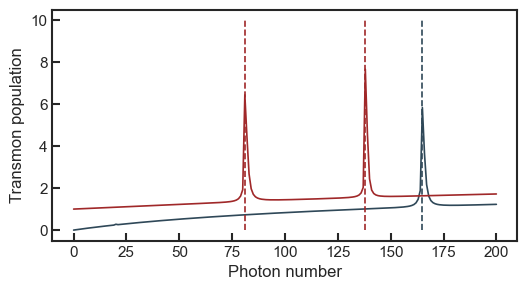

In [161]:
for q in range(2):
    plt.plot((eps_d_vec/2/g)**2,N_t_sorted_q_tot[q])

    for j in range(len(resonance_all_good[q])):
        plt.vlines((resonance_all_good[q][j]/2/g)**2,0,10,color=list_colors[q],linestyle="dashed")

plt.xlabel('Photon number')
plt.ylabel('Transmon population')

In [162]:
len_overlaps = overlap_tot.shape[0]
n_trunc = overlap_tot.shape[1]

index_min = param_resonances["index_min"]
value_min = param_resonances["value_min"]
ratio_v = param_resonances["ratio_v"]
FWHM_size_min = param_resonances["FWHM_size_min"]
FWHM_overlap_min = param_resonances["FWHM_overlap_min"]

value_max = (1 - ratio_v * value_min,)

overlap_tot_max = []
for q_i in range(n_trunc):
    overlap_tot_max_q = []
    for q_f in range(n_trunc):
        overlap_tot_max_q.append(
            np.array(
                FA.find_local_maxima(
                    overlap_tot[:, q_i, q_f],
                    index_min=index_min,
                    value_min=value_min,
                )
            )
        )
    overlap_tot_max.append(overlap_tot_max_q)

overlap_tot_min = []
for q_i in range(n_trunc):
    overlap_tot_min.append(
        np.array(
            FA.find_local_minima(
                overlap_tot[:, q_i, q_i], index_min=index_min, value_max=value_max
            )
        )
    )

res_q = []
for q_i in range(n_trunc):
    overlap_tot_max_q = np.empty((0, 3))
    for q_f in range(n_trunc):
        if q_i != q_f:
            if overlap_tot_max[q_i][q_f].size != 0:
                overlap_tot_max_q = np.vstack(
                    [
                        overlap_tot_max_q,
                        np.hstack(
                            [
                                overlap_tot_max[q_i][q_f],
                                (
                                    q_f * np.ones(len(overlap_tot_max[q_i][q_f]))
                                ).reshape(-1, 1),
                            ]
                        ),
                    ]
                )

    overlap_tot_max_q_sort = FA.sort_by_nth_column(overlap_tot_max_q, n=0)
    if overlap_tot_max_q_sort.shape[0] > 0:
        indices_q = FA.find_matching_indices(
            overlap_tot_min[q_i], overlap_tot_max_q_sort, higher_levels_problem=False
        )
        for i in range(len(indices_q)):
            res_q.append(
                [
                    int(overlap_tot_max_q_sort[indices_q[i][1]][0]),
                    q_i,
                    int(overlap_tot_max_q_sort[indices_q[i][1]][2]),
                    overlap_tot_min[q_i][indices_q[i][0]][1],
                    overlap_tot_max_q_sort[indices_q[i][1]][1],
                ]
            )
            # res_q.append([int(overlap_tot_min[q_i][indices_q[i][0]][0]),q_i,int(overlap_tot_max_q_sort[indices_q[i][1]][2]),overlap_tot_min[q_i][indices_q[i][0]][1],overlap_tot_max_q_sort[indices_q[i][1]][1]])


In [163]:
res_q

[[20, 0, 7, np.float64(0.9951253758270394), np.float64(0.0047554907134647155)],
 [59,
  0,
  10,
  np.float64(0.9997588462949919),
  np.float64(0.00021701411035117359)],
 [165, 0, 11, np.float64(0.8900835451063612), np.float64(0.10991195131977038)],
 [81, 1, 7, np.float64(0.8980924646065299), np.float64(0.1018720353557189)],
 [87,
  1,
  8,
  np.float64(0.9999262777577859),
  np.float64(1.7471438630246314e-05)],
 [154,
  1,
  13,
  np.float64(0.9999262777577859),
  np.float64(4.890761334866532e-05)],
 [5, 4, 9, np.float64(0.990160499811587), np.float64(0.008528716058499457)],
 [97,
  5,
  14,
  np.float64(0.9982870569922196),
  np.float64(0.0016574932686380466)],
 [153,
  5,
  9,
  np.float64(0.9997543671058909),
  np.float64(0.00018273649229967414)],
 [44,
  6,
  16,
  np.float64(0.9999097761797882),
  np.float64(1.2609481896636653e-05)],
 [165,
  6,
  16,
  np.float64(0.9999097761797882),
  np.float64(8.166495895943882e-05)],
 [20, 7, 0, np.float64(0.9950822895410312), np.float64(0.0

In [164]:

def sort_by_nth_column(combined_array, n):
    """
    Sorts an array by the third column.

    Parameters:
    combined_array (numpy.ndarray): The array to sort.

    Returns:
    numpy.ndarray: The sorted array.
    """
    sorted_indices = combined_array[:, n].argsort()
    sorted_array = combined_array[sorted_indices]
    return sorted_array


def find_matching_indices(array_m2, array_n2, higher_levels_problem):
    """
    Finds the indices where the first value of the m-th row in array_m2
    matches the first value of the n-th row in array_n2.

    Parameters:
    array_m2 (numpy.ndarray): An array of size (m x 2).
    array_n2 (numpy.ndarray): An array of size (n x 2).

    Returns:
    list of tuples: A list of tuples where each tuple contains the indices (i, j)
                    indicating that array_m2[i, 0] == array_n2[j, 0].
    """
    matching_indices = []

    for i in range(array_m2.shape[0]):
        matching_j_indices = []

        matched = False

        # Find all matching indices j
        for j in range(array_n2.shape[0]):
            if array_m2[i, 0] == array_n2[j, 0]:
                matching_j_indices.append(j)
                matched = True

        # If there are matching indices, find the one with the maximal second value
        if matching_j_indices:
            max_j = max(matching_j_indices, key=lambda j: array_n2[j, 1])
            matching_indices.append((i, max_j))

        if matched == False and higher_levels_problem == False :
            # Calculate the differences
            differences = np.abs(array_n2[:, 0] - array_m2[i, 0])
            # Get the indices of the two smallest differences
            closest_indices = np.sort(np.argsort(differences)[:2])
            matching_indices.append((i, closest_indices[0]))

            if len(closest_indices) > 1:
                matching_indices.append((i, closest_indices[1]))

    return matching_indices



def remove_rows(array):
    """
    Removes rows j from the array if there is another row i such that
    row_i[0] = row_j[0], row_i[1] = row_j[2], and row_i[2] = row_j[1].

    Parameters:
    array (numpy.ndarray): The input array of size (m x 3).

    Returns:
    numpy.ndarray: The resulting array after removing the specified rows.
    """
    to_remove = np.full(array.shape[0], False)

    for i in range(array.shape[0]):
        for j in range(array.shape[0]):
            if (
                i != j
                and array[i, 1] < array[j, 1]
                and array[i, 0] == array[j, 0]
                and array[i, 1] == array[j, 2]
                and array[i, 2] == array[j, 1]
            ):
                to_remove[j] = True
    return array[~to_remove]




def has_local_extrema(arr):
    n = len(arr)
    if n < 3:
        return (
            False  # Array is too short to have local extrema excluding the endpoints.
        )

    for i in range(1, n - 1):
        if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
            return True  # Local maxima found
        elif arr[i] < arr[i - 1] and arr[i] < arr[i + 1]:
            return True  # Local minima found

    return False  # No local maxima or minima found excluding the endpoints.


def find_fwhm_half(y, peak_index):

    peak_value = y[peak_index]

    # Determine the half-maximum value
    half_max = peak_value / 2.0

    # Find the crossing points on both sides of the peak
    left_side = y[:peak_index]
    right_side = y[peak_index:]

    left_crossing = np.where(left_side <= half_max)[0]
    right_crossing = np.where(right_side <= half_max)[0]

    if len(left_crossing) == 0 or len(right_crossing) == 0:
        fwhm = 0  # No crossing found, FWHM cannot be determined for this peak
    else:
        # Closest points to the peak where the signal crosses the half-maximum value
        left_crossing_point = left_crossing[-1]
        right_crossing_point = right_crossing[0] + peak_index

        # Calculate the widths on both sides
        fwhm_left = peak_index - left_crossing_point
        fwhm_right = right_crossing_point - peak_index

        # Choose the smallest width
        fwhm = min(fwhm_left, fwhm_right)

    return fwhm




In [165]:

_, unique_indices = np.unique(
    np.array(res_q)[:, :-2], axis=0, return_index=True
)

# Use the unique indices to get the unique rows
res_q_unique = np.array(res_q)[sorted(unique_indices)]

res_q_sort = sort_by_nth_column(np.array(res_q_unique), n=0)
res_q_sort_clean = remove_rows(res_q_sort)

swap_statements = []
for i in range(len(res_q_sort_clean)):

    q0, q1, n = (
        int(res_q_sort_clean[i, 1]),
        int(res_q_sort_clean[i, 2]),
        int(res_q_sort_clean[i, 0]),
    )
    swap_statement = True

    # check if this is a unavoided crossing
    for delta in [-2, -1, 1, 2]:
        if (
            f_energies_sorted[q0][n - delta] > f_energies_sorted[q1][n - delta]
            and f_energies_sorted[q0][n + delta]
            < f_energies_sorted[q1][n + delta]
        ):
            swap_statement = False

    if swap_statement == True:
        N_t_sorted_q0 = N_t_sorted[q0][n]
        N_t_sorted_q1 = N_t_sorted[q1][n]
        mean = (N_t_sorted_q0 + N_t_sorted_q1) / 2

        signal = overlap_tot[:, q0, q1]
        FWHM = int(find_fwhm_half(signal, n)) * 3

        if has_local_extrema(N_t_sorted[q0][n - FWHM : n + FWHM]):
            if has_local_extrema(N_t_sorted[q1][n - FWHM : n + FWHM]):
                if N_t_sorted_q0 < N_t_sorted_q1:
                    if np.all(
                        N_t_sorted[q0][n - FWHM : n + FWHM] < mean
                    ) or np.all(N_t_sorted[q1][n - FWHM : n + FWHM] > mean):
                        swap_statement = False
                if N_t_sorted_q0 > N_t_sorted_q1:
                    if np.all(
                        N_t_sorted[q0][n - FWHM : n + FWHM] > mean
                    ) or np.all(N_t_sorted[q0][n - FWHM : n + FWHM] < mean):
                        swap_statement = False

        index_min = np.max([n - FWHM, 0])
        index_max = np.min([n + FWHM, len(N_t_sorted[q0])])
        comp = (
            N_t_sorted[q0][index_min:index_max]
            - N_t_sorted[q1][index_min:index_max]
        )

        if N_t_sorted_q0 < N_t_sorted_q1:
            if np.all(comp < 0):
                swap_statement = False
        if N_t_sorted_q0 > N_t_sorted_q1:
            if np.all(comp > 0):
                swap_statement = False

        if FWHM < FWHM_size_min and overlap_tot[n, q0, q1] < FWHM_overlap_min:
            swap_statement = False

    # print(q0,q1,n,swap_statement)

    swap_statements.append(swap_statement)

index_crit_tot = []
branch_tot = []
gap_tot = []

for q in range(n_trunc):

    current_q = q
    index_crit_q = []
    branch_q = []
    gap_q = []

    branch_q.append(current_q)
    for i in range(len(res_q_sort_clean)):
        [n, q0, q1] = (res_q_sort_clean[i][0:3]).astype(int)
        gap = np.abs(f_energies_sorted[q0][n] - f_energies_sorted[q1][n])
        if q0 == current_q:
            index_crit_q.append(n)
            if swap_statements[i] == True:
                current_q = q1
                gap_q.append(gap)
            else:
                gap_q.append(0)
            branch_q.append(current_q)
        elif q1 == current_q:
            index_crit_q.append(n)
            if swap_statements[i] == True:
                current_q = q0
                gap_q.append(gap)
            else:
                gap_q.append(0)
            branch_q.append(current_q)

    index_crit_tot.append(index_crit_q)
    branch_tot.append(branch_q)
    gap_tot.append(gap_q)

N_t_sorted_q_tot = []
f_energies_sorted_q_tot = []

for q in range(n_trunc):
    N_t_sorted_q = []
    f_energies_sorted_q = []
    for i in range(len(branch_tot[q])):
        if len(branch_tot[q]) > 1:
            if i == 0:
                ind_i = 0
                ind_f = index_crit_tot[q][i]
            elif i == len(branch_tot[q]) - 1:
                ind_i = index_crit_tot[q][i - 1]
                ind_f = len_overlaps + 1
            else:
                ind_i = index_crit_tot[q][i - 1]
                ind_f = index_crit_tot[q][i]
        else:
            ind_i = 0
            ind_f = len_overlaps + 1

        N_t_sorted_q.append(N_t_sorted[branch_tot[q][i]][ind_i:ind_f])
        f_energies_sorted_q.append(
            f_energies_sorted[branch_tot[q][i]][ind_i:ind_f]
        )

    # Concatenate the sorted sub-arrays into a single list
    N_t_sorted_q = [item for list in N_t_sorted_q for item in list]
    N_t_sorted_q_tot.append(N_t_sorted_q)

    f_energies_sorted_q = [
        item for list in f_energies_sorted_q for item in list
    ]
    f_energies_sorted_q_tot.append(f_energies_sorted_q)


In [189]:
res_q_sort_clean[swap_statements]

array([[3.20000000e+01, 1.10000000e+01, 6.00000000e+00, 9.99748212e-01,
        2.26464077e-04],
       [5.80000000e+01, 1.90000000e+01, 2.00000000e+01, 9.99957927e-01,
        9.99998865e-01],
       [6.20000000e+01, 1.90000000e+01, 2.00000000e+01, 9.99957927e-01,
        9.99999790e-01],
       [6.80000000e+01, 1.90000000e+01, 2.00000000e+01, 9.99807646e-01,
        9.99978719e-01],
       [7.20000000e+01, 1.90000000e+01, 2.00000000e+01, 9.99759685e-01,
        9.99923943e-01],
       [7.50000000e+01, 1.90000000e+01, 2.00000000e+01, 9.99915628e-01,
        9.99998394e-01],
       [8.00000000e+01, 1.90000000e+01, 2.00000000e+01, 9.98774217e-01,
        9.98861785e-01],
       [8.10000000e+01, 1.00000000e+00, 7.00000000e+00, 8.98092465e-01,
        1.01872035e-01],
       [8.20000000e+01, 1.90000000e+01, 2.00000000e+01, 9.97780558e-01,
        9.98614451e-01],
       [8.50000000e+01, 1.90000000e+01, 2.00000000e+01, 9.97604174e-01,
        9.99665665e-01],
       [8.80000000e+01, 1.9000

In [190]:
len(swap_statements)

132

In [192]:
swap_statements


[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 T

In [188]:
res_q_sort_clean[34]

array([2.7000000e+01, 1.7000000e+01, 1.6000000e+01, 9.7919008e-01,
       1.5552574e-05])

In [ ]:
swap_statements[43] 

43
55
58
60
62
64
66
67
68
70
73
75
77
79
80
83
84
87
88
90
92
93
96
98


In [195]:
import qutip as qt
import numpy as np

In [216]:
max_fock = 100
at = qt.create(max_fock)
a = qt.destroy(max_fock)

x = (a + at) / np.sqrt(2)
p = (a - at) / (np.sqrt(2) * 1j)

omega = 10
H = omega * at * a
Eigs,Evecs = H.eigenstates()
print(Eigs)


offset = 0.2
H_test = omega * ((x-offset)**2 + p**2 - 1) / 2
Eigs,Evecs = H_test.eigenstates()
print(Eigs-np.min(Eigs))


[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360. 370. 380. 390. 400. 410.
 420. 430. 440. 450. 460. 470. 480. 490. 500. 510. 520. 530. 540. 550.
 560. 570. 580. 590. 600. 610. 620. 630. 640. 650. 660. 670. 680. 690.
 700. 710. 720. 730. 740. 750. 760. 770. 780. 790. 800. 810. 820. 830.
 840. 850. 860. 870. 880. 890. 900. 910. 920. 930. 940. 950. 960. 970.
 980. 990.]
[  0.          10.          20.          30.          40.
  50.          60.          70.          80.          90.
 100.         110.         120.         130.         140.
 150.         160.         170.         180.         190.
 200.         210.         220.         230.         240.
 250.         260.         270.         280.         290.
 300.         310.         320.         330.         340.
 350.         360.         370.         380.         390.
 400.         410.         